## UPDRS-Tapping Assessment - Execution Notebook

This notebooks investigates optimal hand- and fingertapping algorithms as part of the 
ReTune-Dyskinesia project.



### 0. Loading packages and functions, defining paths



In [1]:
# Importing Python and external packages
import os
import sys
import importlib
import json
import pandas as pd
import numpy as np
import sklearn as sk
import scipy
import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec

import seaborn as sns
from scipy import signal
from scipy import stats
from array import array
import datetime as dt
import h5py
from dataclasses import  dataclass, field
from itertools import compress
from typing import Any

In [2]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
# print('mne_bids', mne_bids.__version__)
# print('mne', mne.__version__)
print('sci-py', scipy.__version__)
print('sci-kit learn', sk.__version__)


## developed with:
# Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
# [Clang 10.0.0 ]
# pandas 1.3.4
# numpy 1.20.3
# mne_bids 0.9
# mne 0.24.1
# sci-py 1.7.1
# sci-kit learn 1.0.1

## Currently (own env) since 31.08.22
# Python sys 3.9.12 (main, Jun  1 2022, 06:36:29) 
# [Clang 12.0.0 ]
# pandas 1.4.3
# numpy 1.21.5
# sci-py 1.7.3
# sci-kit learn 1.1.1

Python sys 3.9.12 (main, Jun  1 2022, 06:36:29) 
[Clang 12.0.0 ]
pandas 1.4.3
numpy 1.21.5
sci-py 1.7.3
sci-kit learn 1.1.1


In [3]:
import run_finding_10sec_blocks as run_find_blocks

In [4]:
# own data preprocessing functions
import tap_load_data.updrsTapping_import as tap_import
import tap_load_data.tapping_preprocess as tap_preproc
import tap_load_data.tapping_find_blocks as find_blocks
import tap_load_data.tapping_impact_finder as tap_impact
import tap_load_data.tapping_time_detect as tap_times

import tapping_run as tap_run

# ft extraction
import tap_extract_fts.tapping_featureset as tap_fts_set
import tap_extract_fts.tapping_extract_features as tap_ft_extr
import tap_extract_fts.tapping_feat_calc as ft_calc

# own data exploration functions
import tap_extract_fts.tapping_feat_boxplots as fts_boxplot

# own helper functions
from utils import utils_dataManagement, tmsi_poly5reader, utils_preprocessing

In [7]:
import run_finding_10sec_blocks as run_blocks


## 1. Varvara's ACC Data - Minute-runs containing multiple 10 second-blocks


First data is imported, then 10 sec active tapping blocks are detected, then features are extracted from these blocks.

In [ ]:
### Future main.py-file

# input from json -> location of data (potential subs to exclude)
# tap_import.create_sub_side_lists() -> available patients + files
# pt-files -> tap_import.accData (class) per sub-side-state
# accClasses -> tapping_run.run_updrs_tapping(already_preprocd)


### 1a. Data Import, Extracting and Checking active Tapping-Blocks

In [10]:
importlib.reload(tap_import)
importlib.reload(find_blocks)

# define folder-directory of tap-data

taptask = 'taps_rampStim_3x10s'
verbose=False
toPlot=True
subs_excl = []  #['014', '015']

data_dir = os.path.join(proj_dir, 'data', taptask)
fig_dir = os.path.join(proj_dir, 'figures', taptask)

sub_acc = {}
run_IDs, run_ID_files = tap_import.find_run_IDs(data_dir)
if verbose: print(f'Included subjects/sides to import: {run_IDs}')

subscores = tap_import.tap3x10_updrs_scores(
    file_dir=os.path.join(data_dir, 'updrs_scores'),
    file_name='3x10s_updrs_subscores_all.csv',
    incl_stimRange=True,
)
# Manual correction of error in CSV
del(subscores['007_R_Off']['25mA'])

sub_acc, block_acc, block_ind = {}, {}, {}
for runID in run_IDs:
        
        key = runID[3:]
        if verbose: print('\nSTART', key)
        if key[:3] in subs_excl:
                if verbose: print(f'Skip sub {key}')
                continue

        sub_acc[key] = tap_import.accData(
                OnFile=run_ID_files[runID]['on'],
                OffFile=run_ID_files[runID]['off'],
                orig_fs=250, wanted_fs=250,
                to_resample=False,
                to_check_polarity=True,
                to_check_magnOrder=True,
                verbose=False
        )

        if verbose: print('Acc imported and preprocessed')

        for med in ['Off', 'On']:

                temp_acc, temp_ind = find_blocks.find_active_blocks(
                        acc_arr=getattr(sub_acc[key], med),
                        fs=250, verbose=False, to_plot=False,
                        figsave_dir=fig_dir,
                        figsave_name=f'{key}_{med}_blocks_detected'
                )

                block_acc[f'{key}_{med}'] = temp_acc
                block_ind[f'{key}_{med}'] = temp_ind
                
                if verbose: print(
                        f'\tFor {key}, Med-{med} '
                        f'block-arrays extracted'
                )




013
014
007
015
Sub-scores for full stim-Ampltiude range extracted


#### Manual block-index controle - 3 x 10 sec (only StimOff - stimOn)

<b> If already done -> import json file with Info!! </b>

Compare the detected blocks in the created figure [SUB_SIDE_MED_blocks_detected] with the blocks which should be rated and included. Adjust the block-number selection if necessary, resulting in corresponding selected block-numbers and block_scores 

In [13]:
# ### Standard tap-block selection
# sel_blocks = {}
# for key in block_acc:
#     sel_blocks[key] = {'stimOff': [0, 1, 2], 'stimOn': [-9, -8, -7]}
    
# ### Manual adjustment of tap-block selection based on VISUALISATIONS
# sel_blocks['007_L_Off']['stimOff'] = [1, 2, 3]
# sel_blocks['007_L_Off']['stimOn'] = [-10, -9, -8]
# sel_blocks['013_L_On']['stimOn'] = [-10, -9, -8]
# sel_blocks['014_L_Off']['stimOn'] = [-10, -9, -8]


In [14]:
### To save tap-block selection to JSON
# # f = os.path.join(data_dir, 'prep_jsons', 'manual_block_selection_stimOffOnOnly.json')

# with open (f, 'w') as jsonfile:

#     json.dump(sel_blocks, jsonfile, indent=4)

#     jsonfile.close()

#### Manual block-index controle - 3 x 10 sec (full stim-Amplitude range)

In [7]:
# ### Standard tap-block selection

# std_indx = {
#     '0mA': [0, 1, 2],
#     '05mA': [3, 4, 5],
#     '1mA': [6, 7, 8],
#     '15mA': [9, 10, 11],
#     '2mA': [12, 13, 14],
#     '25mA': [15, 16, 17],
#     '3mA': [18, 19, 20],
# }

# sel_blocks_amps = {}

# for key in subscores:

#     sel_blocks_amps[key] = {}

#     for amp in subscores[key].keys():

#         sel_blocks_amps[key][amp] = std_indx[amp]
    
# ### Manual adjustment of tap-block selection based on VISUALISATIONS
# sel_blocks_amps['007_L_Off'] = {
#     '0mA': [1, 2, 3],
#     '05mA': [4, 5, 6],
#     '1mA': [7, 8, 9],
#     '15mA': [11, 12, 13],
#     '2mA': [14, 15, 16],
#     '25mA': [18, 19, 20],
# }

# sel_blocks_amps['013_L_Off'] = {
#     '0mA': [0, 1, 2],
#     '05mA': [3, 4, 5],
#     '1mA': [7, 8, 9],
#     '15mA': [10, 11, 12],
#     '2mA': [13, 14, 15],
#     '25mA': [16, 17, 18],
# }

# sel_blocks_amps['013_L_On'] = {
#     '0mA': [0, 1, 2],
#     '05mA': [3, 4, 5],
#     '1mA': [6, 7, 8],
#     '15mA': [9, 10, 11],
#     '2mA': [12, 13, 14],
#     '25mA': [16, 17, 18],
# }

# sel_blocks_amps['014_L_Off'] = {
#     '0mA': [0, 1, 2],
#     '05mA': [6, 7, 8],
#     '1mA': [9, 10, 11],
#     '15mA': [12, 13, 14],
#     '2mA': [15, 16, 17],
#     '25mA': [18, 19, 20],
#     '3mA': [21, 22, 23]
# }

# # del(sel_blocks_amps['007_R_Off']['25mA'])

In [15]:
# # f = os.path.join(data_dir, 'prep_jsons', 'manual_block_selection_stimAmpRange.json')

# with open (f, 'w') as jsonfile:

#     json.dump(sel_blocks_amps, jsonfile, indent=4)

#     jsonfile.close()

### 1b. Feature Extraction per 10-sec block

#### VISUALISE FEATURES FOR DEVELOPMENT

013_L_Off
Small slope changes 013_L_Off: 2468
	 slopeChanges * nTaps = 29616
013_R_Off
Small slope changes 013_R_Off: 2844
	 slopeChanges * nTaps = 93852
007_L_Off
Small slope changes 007_L_Off: 2347
	 slopeChanges * nTaps = 35205


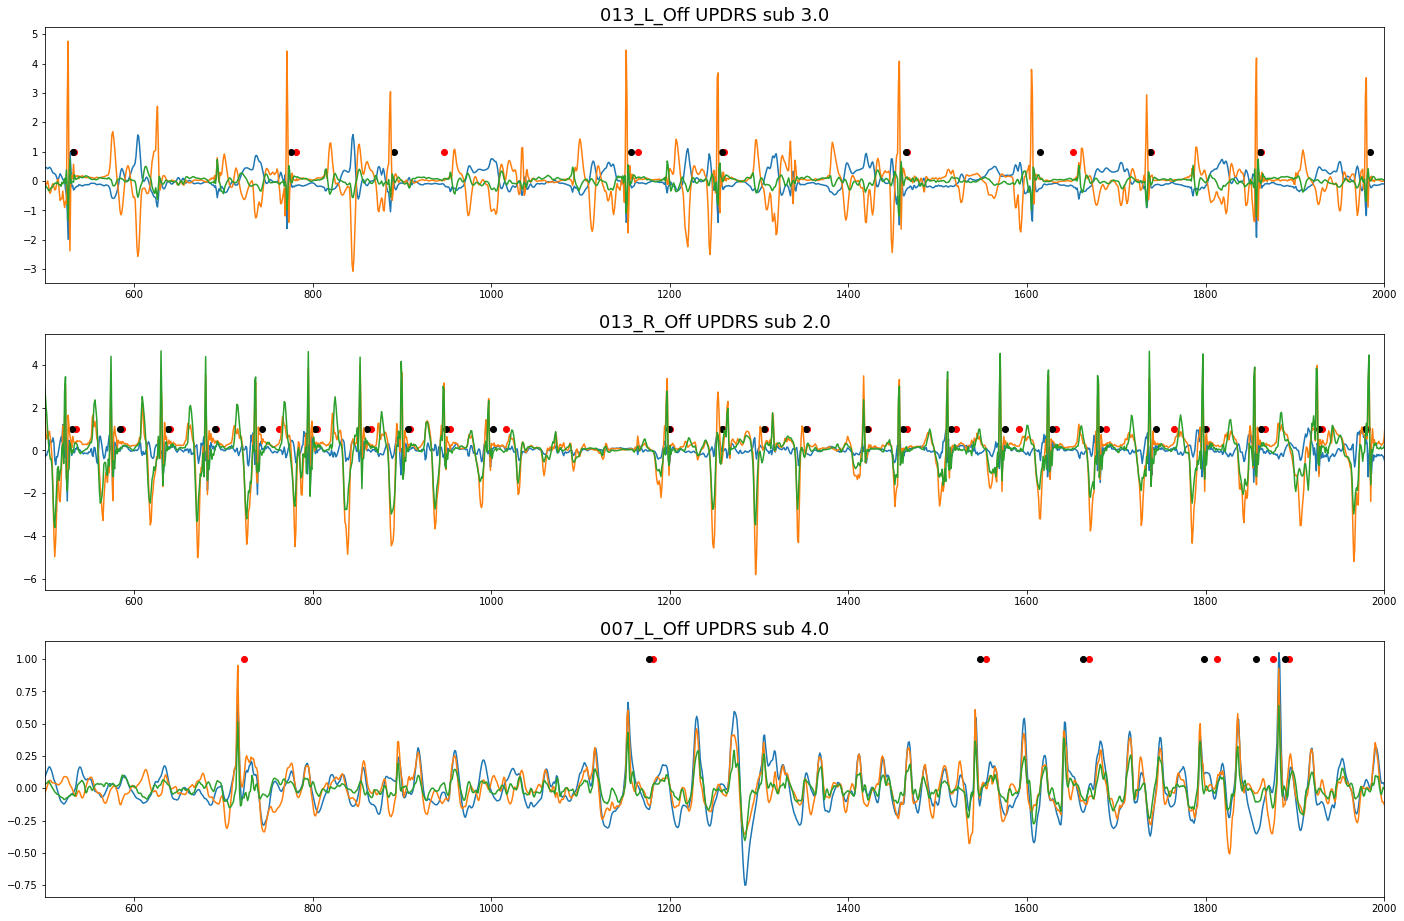

In [1426]:
fig, axes = plt.subplots(3, 1, figsize=(24, 16))

for i, sub in enumerate([
    '013_L_Off',
    '013_R_Off',
    '007_L_Off'
]):

    print(sub)

    tempacc = block_acc[sub][-8]
    temptap, _, _ = tap_run.run_updrs_tapping(
        acc_arr=tempacc, fs=250, already_preprocd=True,
    )

    axes[i].plot(tempacc.T)
    axes[i].scatter(
        [t[0] for t in temptap],
        [1] * len(temptap),
        color='r',
    )
    axes[i].scatter(
        [t[-1] for t in temptap],
        [1] * len(temptap),
        color='k',
    )
    axes[i].set_xlim(500, 2000)

    slopeChanges = smallSlopeChanges(tempacc)
    tempscore = getattr(FEATS[f'{sub}_S1_b2'], 'updrsSubScore')
    axes[i].set_title(
        f'{sub} UPDRS sub {tempscore}',
        fontsize=18,
    )
    
    print(f'Small slope changes {sub}: {slopeChanges}\n'
            f'\t slopeChanges * nTaps = {slopeChanges * len(temptap)}')

plt.show()

#### EXTRACT FEATURES

In [16]:
# check which sessions present

block_acc.keys()

dict_keys(['007_L_Off', '007_L_On', '007_R_Off', '007_R_On', '014_L_Off', '014_L_On', '014_R_Off', '014_R_On', '015_L_Off', '015_L_On', '015_R_Off', '015_R_On', '013_L_Off', '013_L_On', '013_R_Off', '013_R_On'])

In [202]:
importlib.reload(tap_ft_extr)
importlib.reload(tap_ft_extr)
importlib.reload(tap_fts_set)


# Read in priorly Block-Selection
block_indx_json = os.path.join(
    data_dir,
    'prep_jsons',
    'manual_block_selection_stimAmpRange.json'
)
 
with open(block_indx_json) as f:
    block_indx = json.load(f, )


FEATS = {}
fs=250
for run in block_acc.keys():
    print(f'start {run}')

    # to select subjects/runs to extract
    splits = run.split('_')
    # if splits[0] != '007': continue
    # if splits[2] != 'Off': continue

    for S, stim in enumerate(subscores[run].keys()):

        for b, block in enumerate([1, 2, 3]):

            tapscore = subscores[run][stim][b]
            block_n = block_indx[run][stim][b]
            tap_acc = block_acc[run][block_n]

            tap_i, imp_i, acc_temp = tap_run.run_updrs_tapping(
                acc_arr=tap_acc, fs=fs, already_preprocd=True,
            )
            
            if len(tap_i) < 1:
                # print(f'No taps detected for {run}_Stim{S}_block {block}')  # for OnOff
                print(f'No taps detected for {run} {stim}_block {block}')  # for Range
                # continue

            FEATS[f'{run}_{stim}_b{block}'] = tap_ft_extr.tapFeatures(
                triax_arr=acc_temp,
                fs=fs,
                impacts=imp_i,
                tapDict=tap_i,  # result of continTap
                updrsSubScore=tapscore,
            )         





start 007_L_Off
No taps detected for 007_L_Off 2mA_block 1
start 007_L_On
start 007_R_Off
No taps detected for 007_R_Off 05mA_block 1
No taps detected for 007_R_Off 05mA_block 3
No taps detected for 007_R_Off 1mA_block 1
No taps detected for 007_R_Off 1mA_block 2
No taps detected for 007_R_Off 1mA_block 3
No taps detected for 007_R_Off 15mA_block 1
No taps detected for 007_R_Off 15mA_block 3
No taps detected for 007_R_Off 2mA_block 1
No taps detected for 007_R_Off 2mA_block 2
No taps detected for 007_R_Off 2mA_block 3
start 007_R_On
start 014_L_Off
start 014_L_On
start 014_R_Off
start 014_R_On
start 015_L_Off
start 015_L_On
start 015_R_Off
start 015_R_On
start 013_L_Off
start 013_L_On
start 013_R_Off
start 013_R_On


### 1c. Visualise Features as Group with Boxplots

In [154]:
importlib.reload(fts_boxplot)
importlib.reload(ft_calc)

### PM, TODO: include runs without detected taps in boxplots
# or indicate the number of them incl updrs subscore

ftAx = 'svm'
fts_include = [
    'freq',
    'nTaps',
    'ampDecrement',
    'dirChange_run',
    'dirChange_taps',
    f'runRMS_{ftAx}',
    f'tapRMS_{ftAx}',
    f'impactRMS_{ftAx}',
    f'upVelo_{ftAx}',
]
merge_meth = 'coefVar'
# for merge_meth in ['mean', 'sum', 'stddev', 'trend_slope']:
tempScoreDict = fts_boxplot.combineFeatsPerScore(
    ftDict=FEATS, fts_include=fts_include,
    merge_method=merge_meth,
)
fts_boxplot.plot_boxplot_feats_per_subscore(
    fts_include=fts_include,
    featDict=tempScoreDict,
    merge_method=merge_meth,
    plot_title='Stim-Ramp 3x10sec Tapping',
    figsave_name=f'stimRamp_3x10_4pts_{ftAx}Fts_{merge_meth}_v2',
    figsave_dir=os.path.join(
        fig_dir, 'fts_boxplots', 'results_fullRange'
    ),
    show=False,
)


skipped 007_L_Off_2mA_b1, no taps available
skipped 007_R_Off_05mA_b1, no taps available
skipped 007_R_Off_05mA_b3, no taps available
skipped 007_R_Off_1mA_b1, no taps available
skipped 007_R_Off_1mA_b2, no taps available
skipped 007_R_Off_1mA_b3, no taps available
skipped 007_R_Off_15mA_b1, no taps available
skipped 007_R_Off_15mA_b3, no taps available
skipped 007_R_Off_2mA_b1, no taps available
skipped 007_R_Off_2mA_b2, no taps available
skipped 007_R_Off_2mA_b3, no taps available
skipped 007_L_Off_2mA_b1, no taps available
skipped 007_R_Off_05mA_b1, no taps available
skipped 007_R_Off_05mA_b3, no taps available
skipped 007_R_Off_1mA_b1, no taps available
skipped 007_R_Off_1mA_b2, no taps available
skipped 007_R_Off_1mA_b3, no taps available
skipped 007_R_Off_15mA_b1, no taps available
skipped 007_R_Off_15mA_b3, no taps available
skipped 007_R_Off_2mA_b1, no taps available
skipped 007_R_Off_2mA_b2, no taps available
skipped 007_R_Off_2mA_b3, no taps available
skipped 007_L_Off_2mA_b1

### 1d. Visualise single Features over Tap-course

In [151]:
ft = 'tapRMS_svm'

sub = '007'
side='L'

mA_range = ['0', '05', '1', '15', '2', '25']

colors = {'Off': 'blue', 'On': 'green'}
fs=14

for ft in [
    'tapRMS_svm',
    # 'upVelo_svm',
    # 'impactRMS_svm',
    # 'dirChange_taps',
    # 'tap_durations',
]:

    plt.figure(figsize=(12, 6))

    # get mean feature-course over 3 tapping-blocks of 10 sec
    for med in ['Off', 'On']:

        for a, mA in enumerate(mA_range):

            try:
                meanFt = [
                    getattr(
                        FEATS[f'{sub}_{side}_{med}_{mA}mA_b{bN}'],
                        ft
                    ) for bN in [1,2,3]
                ]

            except KeyError:  # tap-run not existing
                continue  # dont calculate and plot line

            except AttributeError:  # no taps detected -> no features extracted
                meanFt = []
                emptyCount = ' '

                for bN in [1,2,3]:
                    key = f'{sub}_{side}_{med}_{mA}mA_b{bN}'
                    
                    if ft in vars(FEATS[key]).keys():
                        meanFt.append(getattr(FEATS[key], ft))
                    
                    else:
                        emptyCount += '*'
                
                if meanFt == []:  # all runs without taps/features
                    meanFt = [[0]]

            # transform ft-lists per run into mean array
            maxLen = max(
                [len(meanFt[n]) for n in range(len(meanFt))]
            )
            meanFtArr = np.array(
                [[np.nan] * maxLen] * len(meanFt))
            
            for n, l in enumerate(meanFt):
                meanFtArr[n, :len(l)] = l
            
            meanFtPlot = np.nanmean(meanFtArr, axis=0)

            # average updrsSubScore over 3 runs
            meanTapScore = np.round(np.mean([
                getattr(
                    FEATS[f'{sub}_{side}_{med}_{mA}mA_b{bN}'],
                    'updrsSubScore'
                ) for bN in [1,2,3]
            ]), 1)

            tapLabel = f'Med{med} {mA} mA  (updrs {meanTapScore})'
            
            try:
                tapLabel += emptyCount
                del(emptyCount)

            except:
                tapLabel = tapLabel

            plt.plot(
                meanFtPlot, c=colors[med],
                alpha=.1 + (.15 * a),
                label=tapLabel,
            )
            

            

    plt.ylabel(f'{ft} (a.u.)', size=fs,)
    plt.xlabel('Taps over time (# of tap)', size=fs,)

    plt.tick_params(axis='both', size=fs, labelsize=fs)

    plt.legend(
        frameon=False, ncol=1,
        bbox_to_anchor=(1, .9), loc='upper left',
        fontsize=fs,
    )

    plt.title(
        f'Feature course of "{ft}"    -     '
        f'Sub-{sub}, {side}-side'
        f'\n(mean over 3 10-sec blocks in same condition)',
        fontsize=fs+6,
    )
    plt.tight_layout()

    plt.savefig(
        os.path.join(
            fig_dir,
            'ft_course_tapping',
            f'TEST____{sub}_{side}_ftCourse_{ft}'
        ),
        dpi=150, facecolor='w',
    )
    plt.close()

/var/folders/7d/4ptht2m910d1y872jrgp9cq40000gp/T/ipykernel_32352/1711045685.py:63: RuntimeWarning: Mean of empty slice
  meanFtPlot = np.nanmean(meanFtArr, axis=0)


## 2. Johannes ACC Data - Individual 30 second-runs, only tapping


Compared to workflow for "3 x 10s tapping blocks", here there is no detection of active tapping blocks. Full time series of 30 seconds are used for single-tap-detection and feature extraction.

### 2a. Feature Extraction and Visualisation of sub <b>with</b> UPDRS-subscores

In [8]:
importlib.reload(tap_run)
importlib.reload(tap_times)
importlib.reload(tap_ft_extr)
importlib.reload(tap_fts_set)
importlib.reload(tap_import)
importlib.reload(tap_impact)
importlib.reload(tap_preproc)

# define directory and filename
jb_dir = '/Users/jeroenhabets/Research/CHARITE/projects/tapping/data/JB_30s'
jb_fig_dir = '/Users/jeroenhabets/Research/CHARITE/projects/tapping/figures/JB_30s'

mat_dat_f = 'tapsMat.mat'
csv_meta_f = 'tapsMeta.csv'

# Import acc-traces
mat_dat = tap_import.matlab_import(os.path.join(
    jb_dir, mat_dat_f))
fname = mat_dat.filename.split(sep='/')[-1]
mat_dat = mat_dat[fname[:-4]]

# import meta-data
meta = tap_import.import_meta_aDBS(
    os.path.join(jb_dir, csv_meta_f)
)

# Import subscores
scores218 = np.genfromtxt(
    os.path.join(jb_dir, 'updrs_218.txt'),
    delimiter=',', dtype=str,
)
df_scores218 = pd.DataFrame(data=scores218[1:, :], columns=scores218[0, :])
arr_scores218 = scores218[1:, 2:]
scores545 = arr_scores218[-28:,:]

fs=250

acc545 = mat_dat[:, :, -28:]  # check mat_dat here
fts545 = {}

# ### check tap detection
tap545 = {}
imp545 = {}
accproc545 = {}

updrs_times = {'t1': (2 * fs, 12 * fs), 't2': (20 * fs, 30 * fs)}

accDat = acc545

for run_id in np.arange(acc545.shape[2]):
    
    raw_triax = acc545[:, :, run_id].T

    for t_i, t in enumerate(updrs_times.keys()):

        # print(f'\nStart run_id {run_id}, timepoint {t_i}')

        sig = raw_triax[
            :, updrs_times[t][0]:updrs_times[t][1]
        ]
        subscore = scores545[run_id, t_i]

        tap_inds, imp_inds, proc_triax = tap_run.run_updrs_tapping(
            acc_arr=sig, fs=fs, already_preprocd=False, #orig_fs=4000,
        )
        # ## check tap detect
        tap545[f'run{run_id}_t{t_i}'] = tap_inds
        imp545[f'run{run_id}_t{t_i}'] = imp_inds
        accproc545[f'run{run_id}_t{t_i}'] = proc_triax

        fts545[f'run{run_id}_t{t_i}'] = tap_ft_extr.tapFeatures(
            triax_arr=proc_triax,
            fs=fs,
            impacts=imp_inds,
            tapDict=tap_inds,
            updrsSubScore=subscore,
        )



/Users/jeroenhabets/Research/CHARITE/projects/tapping/data/JB_30s/tapsMat.mat imported with h5py


NameError: name 'mat' is not defined

In [102]:
sub = '545'

ax_in = 'svm'  # 'ax' or 'svm'

fts_include = [
    'freq',
    'nTaps',
    f'tapRMS_{ax_in}',
    f'upVelo_{ax_in}',
    f'impactRMS_{ax_in}',
    'dirChange_taps',
]
merge_meth = 'coefVar'

tempScoreDict = fts_boxplot.combineFeatsPerScore(
    ftDict=fts545, fts_include=fts_include,
    merge_method=merge_meth,
)
fts_boxplot.plot_boxplot_feats_per_subscore(
    fts_include=fts_include,
    featDict=tempScoreDict,
    merge_method=merge_meth,
    plot_title=f'Sub {sub}: Feature distribution vs UPDRS subscores (28 aDBS traces)',
    figsave_name=f'sub{sub}_aDBS_box_{ax_in}fts_{merge_meth}',
    figsave_dir=os.path.join(jb_fig_dir, 'fts_boxplot'),
    show=False,
)


### 2b. Extract Features and Store them for Subs <b>without</b> UPDRS-subscores

In [28]:
mat_dat.shape

(8001, 3, 218)

In [127]:
importlib.reload(tap_run)
importlib.reload(tap_times)
importlib.reload(tap_ft_extr)
importlib.reload(tap_fts_set)
importlib.reload(tap_import)
importlib.reload(tap_impact)
importlib.reload(tap_preproc)

# define directory and filename
jb_dir = '/Users/jeroenhabets/Research/CHARITE/projects/tapping/data/JB_30s'
jb_fig_dir = '/Users/jeroenhabets/Research/CHARITE/projects/tapping/figures/JB_30s'

mat_dat_f = 'tapsMat.mat'
csv_meta_f = 'tapsMeta.csv'

# Import acc-traces
mat_dat = tap_import.matlab_import(os.path.join(
    jb_dir, mat_dat_f))
fname = mat_dat.filename.split(sep='/')[-1]
mat_dat = mat_dat[fname[:-4]]

# import meta-data
meta = tap_import.import_meta_aDBS(
    os.path.join(jb_dir, csv_meta_f)
)
# subs = meta['subject'].unique()

fs=250

accAll = mat_dat
ftsAll = {}

# fts529 = {}

for run_id in np.arange(accAll.shape[2]):
    
    sig = accAll[:, :, run_id].T  # tri-axial acc sig

    tap_inds, imp_inds, proc_triax = tap_run.run_updrs_tapping(
        acc_arr=sig, fs=fs, already_preprocd=False,
    )

    ftsAll[f'run{run_id}'] = tap_ft_extr.tapFeatures(
        triax_arr=proc_triax,
        fs=fs,
        impacts=imp_inds,
        tapDict=tap_inds,  # result of continTap
        # updrsSubScore=subscore,
    )
    
    # if meta.iloc[run_id]['subject'] == '529':
    #     fts529[f'run{run_id}'] = tap_ft_extr.tapFeatures(
    #         triax_arr=proc_triax,
    #         fs=fs,
    #         impacts=imp_inds,
    #         tapDict=tap_inds,  # result of continTap
    #         # updrsSubScore=subscore,
    #     )
    # else:
    #     continue



/Users/jeroenhabets/Research/CHARITE/projects/tapping/data/JB_30s/tapsMat.mat imported with h5py


#### Visualise all aDBS runs

In [111]:
import utils.utils_aDBS_JB as utils_aDBS

In [128]:

aDBSfts = utils_aDBS.aDBS_subjects(meta=meta, ftsAll=ftsAll)
# submeta = meta[meta['subject'] == '529']
# subFts = utils_aDBS.aDBS_subjects(meta=submeta, ftsAll=fts529)


In [129]:
print(vars(aDBSfts.sub533.cOn).keys())

dict_keys(['sub', 'run_name', 'stim', 'trial', 'fts'])


In [400]:
"""
Change sub / side for run_ids
change stim_amps for stim states
"""

colors = {
    'cOff': 'red',
    'cOn': 'green',
    'a4': 'purple',  # largest B-supression (best)
    'a9': 'orange',  # smallest B-supression (worst)
    'a': 'blue'
}
lws = {'c': 2, 'a': .5}
fs=14

fts_incl = [
    'tapRMS_svm',
    'upVelo_svm',
    'impactRMS_svm',
    'dirChange_taps',
    'tap_durations',
]

fts_name = [
    'total Tap RMS',
    'upwards Movement',
    'closing-impact RMS',
    'Hesitations',
    'Tap durations'
]

for sub in aDBSfts.subs:

    fig, axes = plt.subplots(
        len(fts_incl), 1, figsize=(12, 12)
    )

    temp_sub = getattr(aDBSfts, f'sub{sub}')

    for ax, ft in enumerate(fts_incl):

        axes[ax].plot(
            getattr(temp_sub.cOff.fts, ft),
            c=colors['cOff'], lw=lws['c'],
            label='cOff',
        )
        axes[ax].plot(
            getattr(temp_sub.cOn.fts, ft),
            c=colors['cOn'], lw=lws['c'],
            label='cOn',
        )

        for aRun in temp_sub.run_names:

            if aRun[0] != 'a': continue

            aN = int(aRun[1])

            aRun = getattr(temp_sub, aRun)

            if aN in [4, 9]:

                axes[ax].plot(
                    getattr(aRun.fts, ft),
                    c=colors[f'a{aN}'], lw=lws['c'],
                    label=f'aDBS_preset{aN}',
                    # alpha=.11 * aN,
                )

            else:

                axes[ax].plot(
                    getattr(aRun.fts, ft),
                    c=colors['a'], lw=lws['a'],
                    # label=f'aDBS_{aN}',
                    alpha=.3,
                )


        axes[ax].set_title(
            fts_name[ax], size=fs + 2)

    
        # ADD aDBS 
    
    axes[-1].legend(
        frameon=False, fontsize=fs, ncol=4,
        bbox_to_anchor=[.5, -.35], loc='center'
    )
        

            

    # plt.ylabel(f'{ft} (a.u.)', size=fs,)
    # plt.xlabel('Taps over time (# of tap)', size=fs,)

    plt.tick_params(axis='both', size=fs, labelsize=fs)

    # plt.legend(
    #     frameon=False, ncol=1,
    #     bbox_to_anchor=(1, .9), loc='upper left',
    #     fontsize=fs,
    # )

    plt.suptitle(
        f'aDBS-sub {sub}: Tapping features',
        fontsize=fs+6, x=.2, ha='center', y=.98
    )
    plt.tight_layout()

    plt.savefig(
        os.path.join(
            jb_fig_dir,
            'ft_course',
            f'{sub}_aDBS_tapFeatures'
        ),
        dpi=150, facecolor='w',
    )
    plt.close()

In [401]:
jb_fig_dir

'/Users/jeroenhabets/Research/CHARITE/projects/tapping/figures/JB_30s'

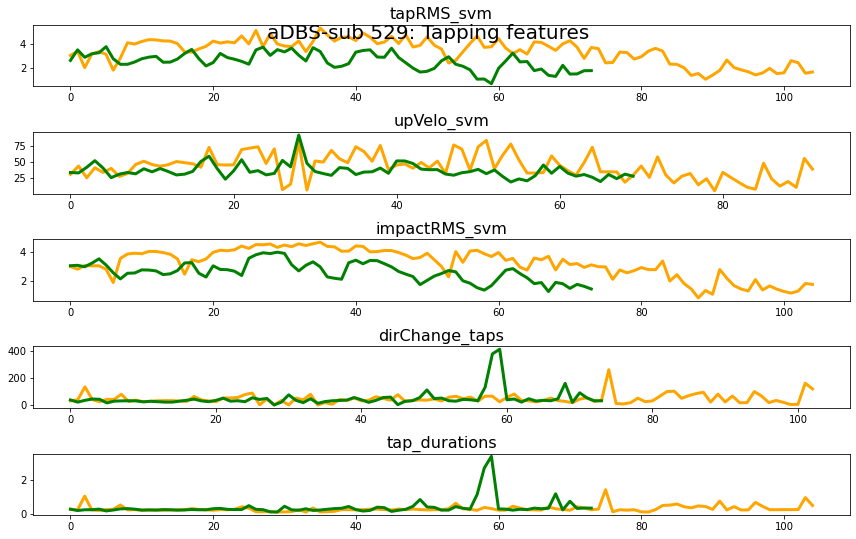

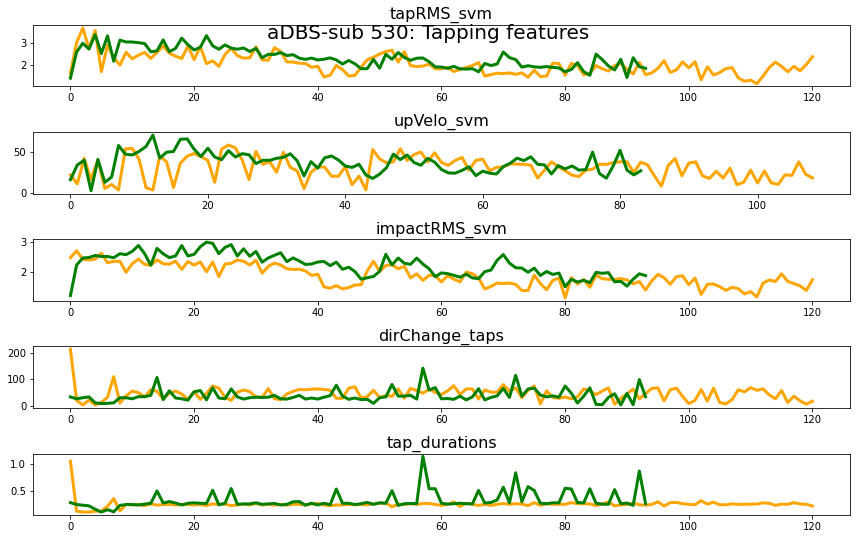

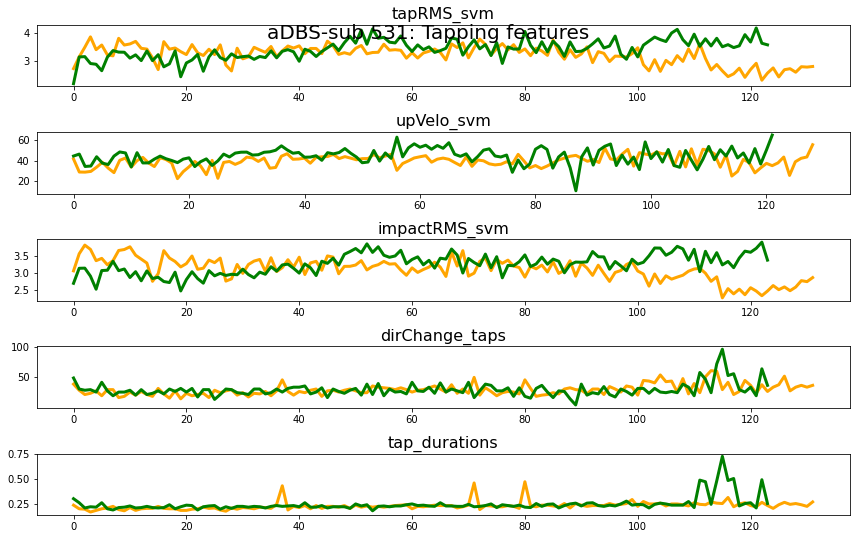

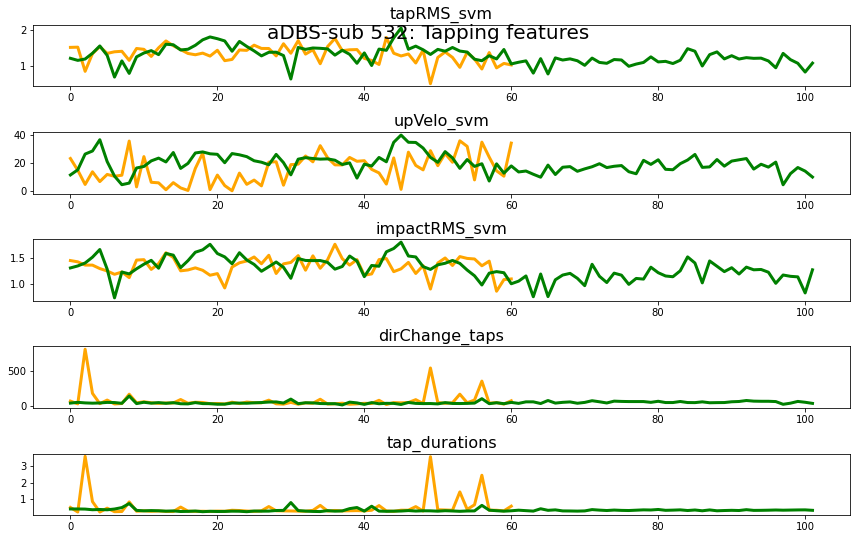

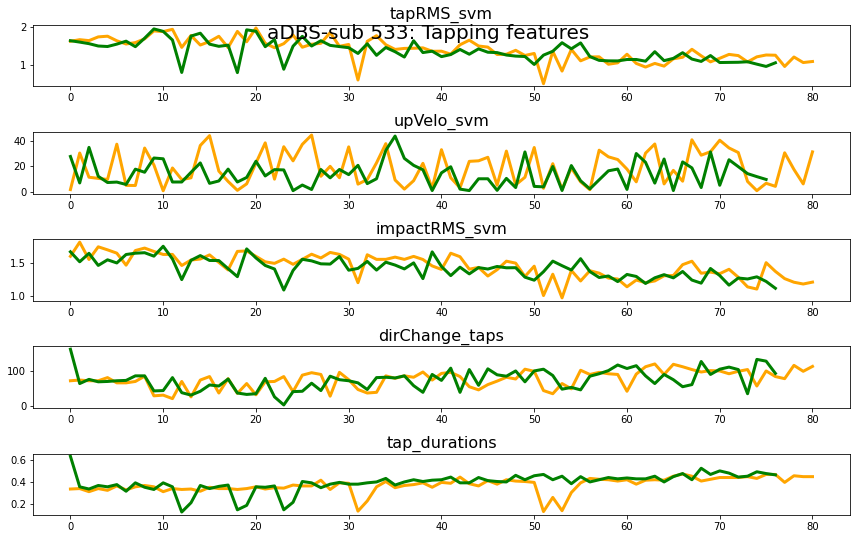

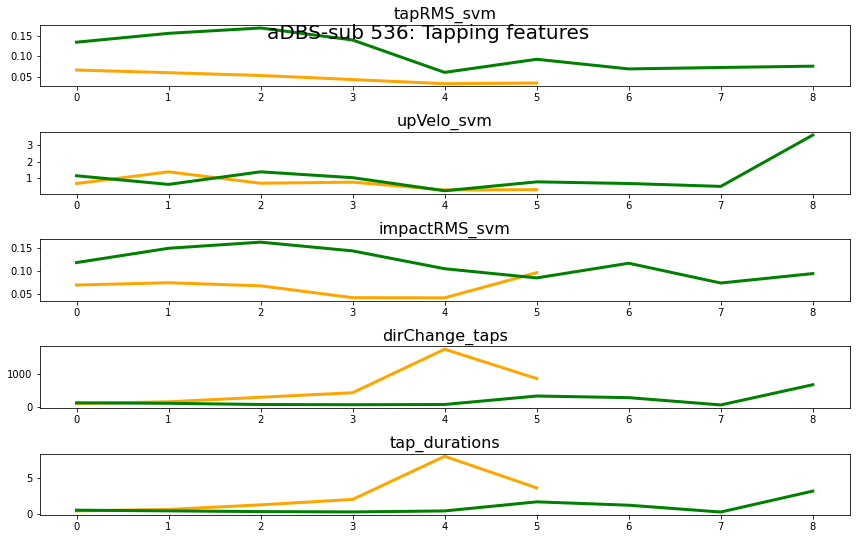

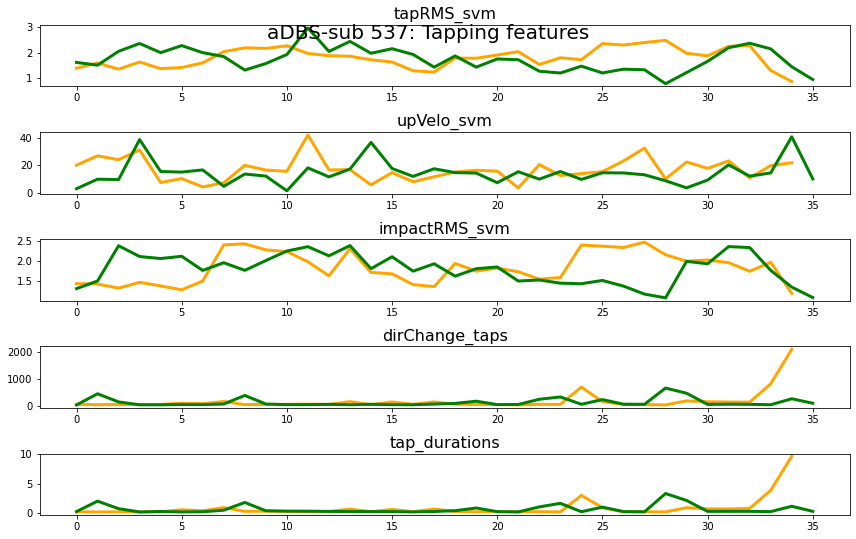

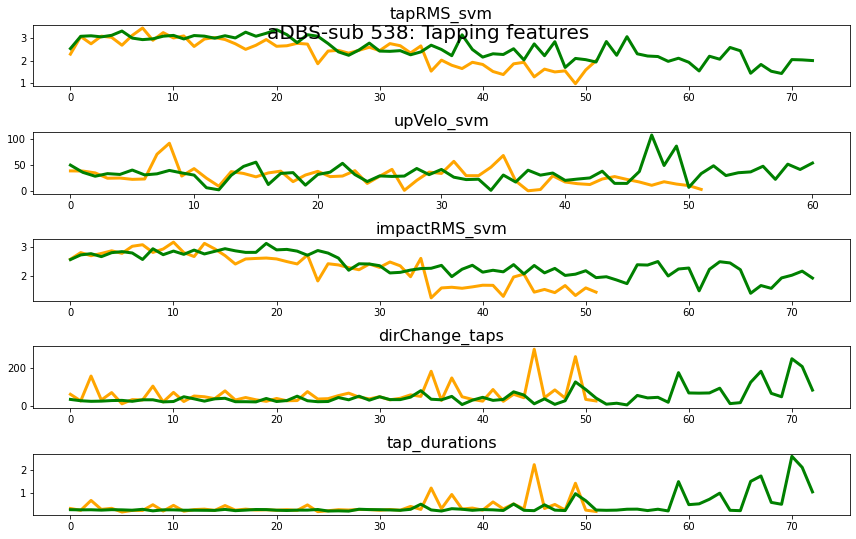

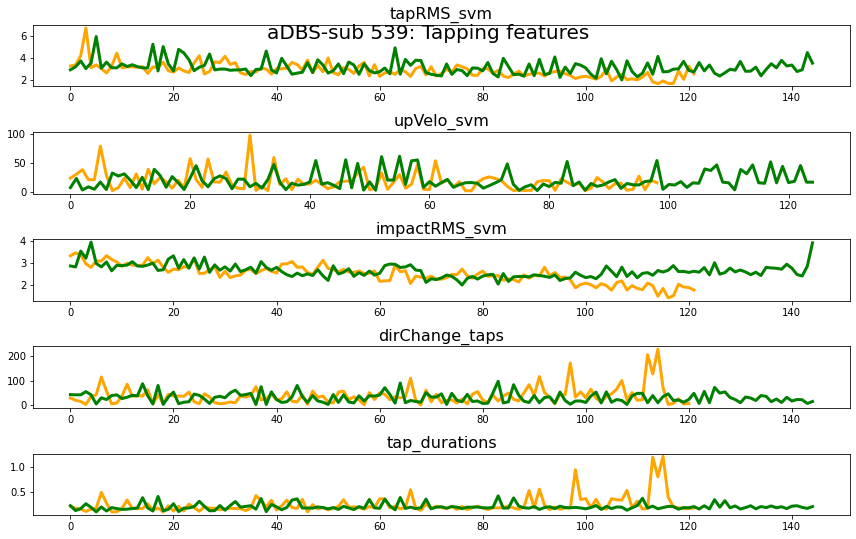

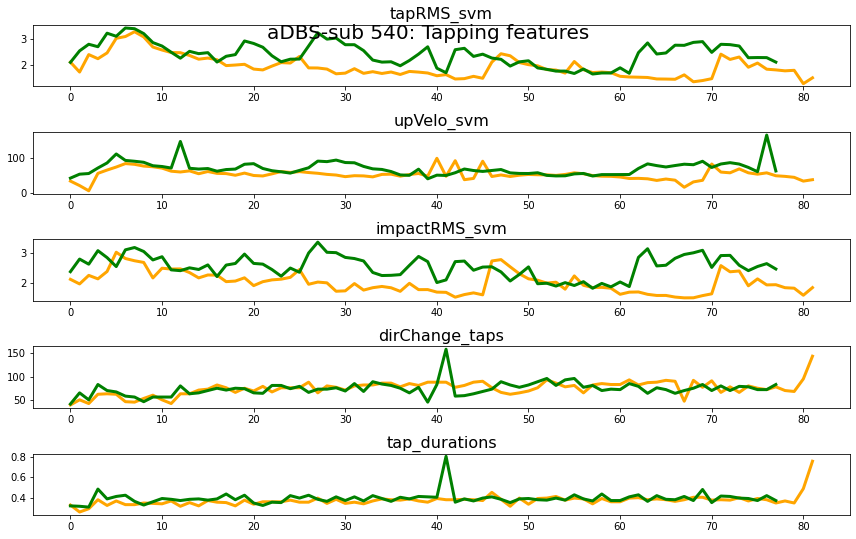

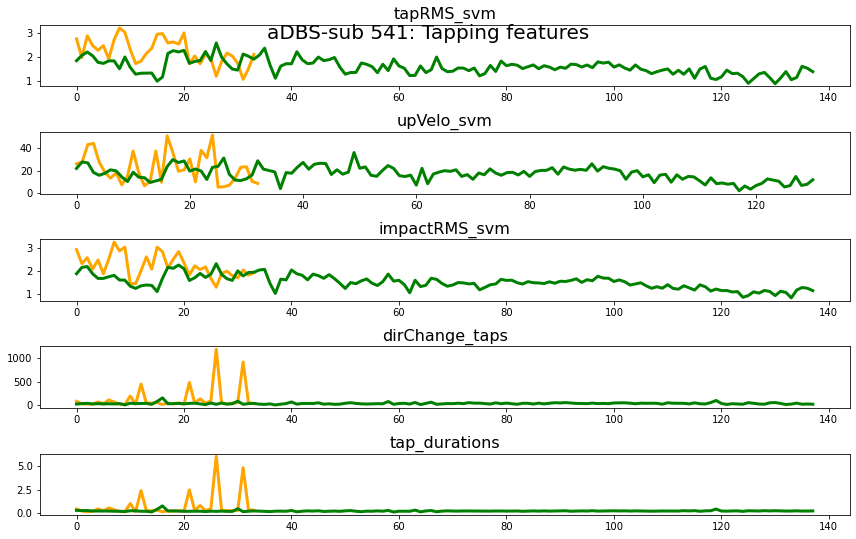

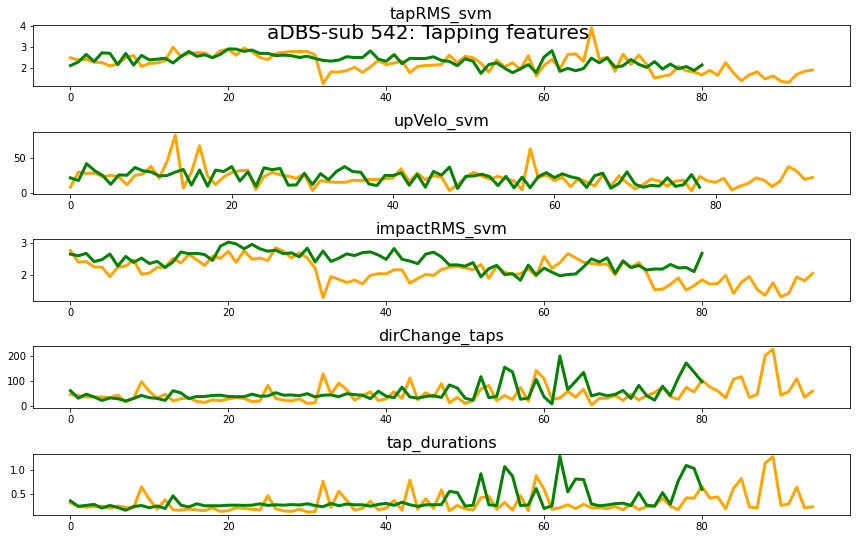

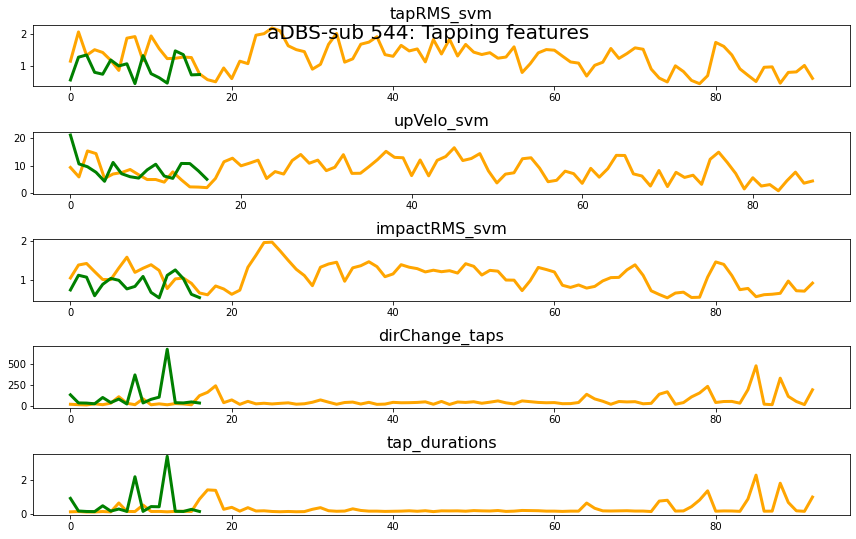

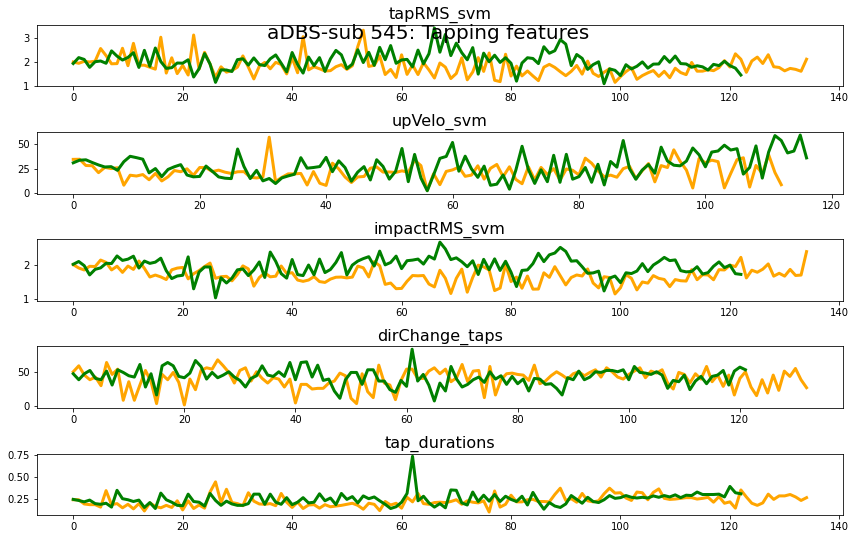

In [131]:
"""
Change sub / side for run_ids
change stim_amps for stim states
"""

colors = {
    'cOff': 'orange',
    'cOn': 'green',
    'a': 'blue'
}
lws = {'c': 3, 'a': 1}
fs=14

fts_incl = [
    'tapRMS_svm',
    'upVelo_svm',
    'impactRMS_svm',
    'dirChange_taps',
    'tap_durations',
]

for sub in aDBSfts.subs:

    fig, axes = plt.subplots(
        len(fts_incl), 1, figsize=(12, 8)
    )

    temp_sub = getattr(aDBSfts, f'sub{sub}')

    for ax, ft in enumerate(fts_incl):

        axes[ax].plot(
            getattr(temp_sub.cOff.fts, ft),
            c=colors['cOff'], lw=lws['c'],
            label='cOff',
        )
        axes[ax].plot(
            getattr(temp_sub.cOn.fts, ft),
            c=colors['cOn'], lw=lws['c'],
            label='cOn',
        )

        # for aRun in temp_sub.run_names:

        #     if aRun[0] != 'a': continue

        #     aN = int(aRun[1])

        #     aRun = getattr(temp_sub, aRun)

        #     axes[ax].plot(
        #         getattr(aRun.fts, ft),
        #         c=colors['a'], lw=lws['a'],
        #         label=f'aDBS_{aN}',
        #         alpha=.11 * aN,
        #     )


        axes[ax].set_title(ft, size=fs + 2)

    
        # ADD aDBS 
    
    # axes[0].legend(
    #     frameon=False, fontsize=fs, ncol=2,
    #     bbox_to_anchor=[.75, 2], loc='upper left'
    # )
        

            

    # plt.ylabel(f'{ft} (a.u.)', size=fs,)
    # plt.xlabel('Taps over time (# of tap)', size=fs,)

    # plt.tick_params(axis='both', size=fs, labelsize=fs)

    # plt.legend(
    #     frameon=False, ncol=1,
    #     bbox_to_anchor=(1, .9), loc='upper left',
    #     fontsize=fs,
    # )

    plt.suptitle(
        f'aDBS-sub {sub}: Tapping features',
        fontsize=fs+6, x=.5, ha='center', y=.9
    )
    plt.tight_layout()

    # plt.savefig(
    #     os.path.join(
    #         fig_dir,
    #         'ft_course_tapping',
    #         f'TEST____{sub}_{side}_ftCourse_{ft}'
    #     ),
    #     dpi=150, facecolor='w',
    # )
    plt.show()

In [67]:
# ### Code to export features

# importlib.reload(ft_calc)

# ft_sel = [
#     'nTaps',
#     'freq',
#     'tapRMS_ax',
#     'impactRMS_ax',
#     'upVelo_svm',
#     'dirChange_taps',
# ]

# ft_colNames = [
#     'nTaps',
#     'freq',
#     'tapRMS_ax_mean',
#     'impactRMS_ax_mean',
#     'upVelo_svm_mean',
#     'dirChange_taps_coefVar',
# ]

# fts_df = pd.DataFrame(
#     data=ft_calc.nan_array([
#         len(ftsAll.keys()), len(ft_sel)
#     ]),
#     columns=ft_sel,
#     index=ftsAll.keys(),
# )


# for run_id in ftsAll.keys():

#     for ft in ft_sel:
        
#         value = getattr(ftsAll[run_id], ft)

#         if ft in ['nTaps', 'freq']:
#             value = value
        
#         elif ft == 'dirChange_taps':
#             value = ft_calc.aggregate_arr_fts(
#                 'coefVar', value
#             )
        
#         else:
#             value = ft_calc.aggregate_arr_fts(
#                 'mean', value
#             )
        
#         fts_df.loc[run_id][ft] = value


# fts_df.to_csv(
#     os.path.join(
#         '/Users/jeroenhabets/Research/CHARITE/projects/tapping/results/JB_30s',
#         'table_218subs_6fts.csv'
#     ),
#     header=True, index=True,
# )

/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/code/lfpecog_features/tapping_feat_calc.py:87: RuntimeWarning: invalid value encountered in true_divide
  print(values)


artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added


# 3. Clustering & Classifying

- Candidate vetors based on descriptives and concept
    - nTaps
    - freq
    - upVelo sum [std-dev + coefVar]
    - impact RMS [coefVar + stddev]
    - tapRMS and impactRMS [sum]
    - 
- include per run (array tap-features): sum, mean, stddev, trend_slope

- Cluster on UPDRS 4?

### 3a. ML-Vector Preparation

In [201]:
importlib.reload(tap_fts_set)

FEATS['007_L_Off_1mA_b1'].impactRMS_svm

tap_fts_set.amplitudeDecrement(
    [
        FEATS['007_L_Off_1mA_b1'].tapRMS_svm,
        FEATS['007_L_Off_1mA_b1'].impactRMS_svm,
        FEATS['007_L_Off_1mA_b1'].upVelo_svm
    ]
)

10

In [187]:
valid_samples

['007_L_Off_0mA_b1',
 '007_L_Off_0mA_b2',
 '007_L_Off_0mA_b3',
 '007_L_Off_05mA_b1',
 '007_L_Off_05mA_b2',
 '007_L_Off_05mA_b3',
 '007_L_Off_1mA_b1',
 '007_L_Off_1mA_b2',
 '007_L_Off_1mA_b3',
 '007_L_Off_15mA_b1',
 '007_L_Off_15mA_b2',
 '007_L_Off_15mA_b3',
 '007_L_Off_2mA_b2',
 '007_L_Off_2mA_b3',
 '007_L_Off_25mA_b1',
 '007_L_Off_25mA_b2',
 '007_L_Off_25mA_b3',
 '007_L_On_0mA_b1',
 '007_L_On_0mA_b2',
 '007_L_On_0mA_b3',
 '007_L_On_05mA_b1',
 '007_L_On_05mA_b2',
 '007_L_On_05mA_b3',
 '007_L_On_1mA_b1',
 '007_L_On_1mA_b2',
 '007_L_On_1mA_b3',
 '007_L_On_15mA_b1',
 '007_L_On_15mA_b2',
 '007_L_On_15mA_b3',
 '007_L_On_2mA_b1',
 '007_L_On_2mA_b2',
 '007_L_On_2mA_b3',
 '007_L_On_25mA_b1',
 '007_L_On_25mA_b2',
 '007_L_On_25mA_b3',
 '007_L_On_3mA_b1',
 '007_L_On_3mA_b2',
 '007_L_On_3mA_b3',
 '007_R_Off_0mA_b1',
 '007_R_Off_0mA_b2',
 '007_R_Off_0mA_b3',
 '007_R_Off_05mA_b2',
 '007_R_Off_15mA_b2',
 '007_R_On_0mA_b1',
 '007_R_On_0mA_b2',
 '007_R_On_0mA_b3',
 '007_R_On_05mA_b1',
 '007_R_On_05mA_b

In [186]:
importlib.reload(ft_calc)

ft_axis = 'svm'
single_ft_names = [
    'nTaps',
    'freq',
    'ampDecrement'
]
arr_ft_names = [
    f'tapRMS_{ft_axis}',
    f'upVelo_{ft_axis}',
    f'impactRMS_{ft_axis}',
    'dirChange_taps',
]
ft_aggr_to_add = [
    'mean', 'coefVar', 'variance', 'sum', 'trend_slope'
]


valid_sel = [
    len(FEATS[s].tapDict) > 0 for s in FEATS.keys()
]
valid_samples = list(compress(FEATS.keys(), valid_sel))
n_samples = len(valid_samples)

Xdf = pd.DataFrame(
    data=np.zeros((
        n_samples,
        len(single_ft_names) + (
            len(arr_ft_names) * len(ft_aggr_to_add)
        )
    )), columns=[single_ft_names + [
        f'{f}_{m}' for f in arr_ft_names for m in ft_aggr_to_add
    ]]
)
y = ft_calc.nan_array([Xdf.shape[0], 1])
for s in range(Xdf.shape[0]):
    y[s] = getattr(
        FEATS[valid_samples[s]],
        'updrsSubScore'
    )

for ft in single_ft_names:
    for s, sam in enumerate(valid_samples):
        try:
            ft_value = getattr(FEATS[sam], ft)
        except AttributeError:
            print(sam)

        Xdf.iloc[s][ft] = ft_value


max_nTaps = np.max([FEATS[k].nTaps for k in valid_samples])

arr_feats = ft_calc.nan_array([
    len(arr_ft_names),
    max_nTaps,
    n_samples
])

for f, ft in enumerate(arr_ft_names):

    for s, sam in enumerate(valid_samples):

        ft_values = getattr(FEATS[sam], ft)
        arr_feats[f, :len(ft_values), s] = ft_values

# Normalise vector per array-feature over all samples
for ft_row in range(len(arr_ft_names)):

    vec_max = np.nanmax(arr_feats[ft_row, :, :])
    arr_feats[ft_row, :, :] = arr_feats[ft_row, :, :] / vec_max

# Normalise single feature over all samples
for ft in single_ft_names:

    fmax = np.max(Xdf[ft])
    Xdf[ft] = Xdf[ft] / fmax

# Aggregate array features
for ft, ft_name in enumerate(arr_ft_names):

    for m in ft_aggr_to_add:

        for s in np.arange(Xdf.shape[0]):
            
            value = ft_calc.aggregate_arr_fts(
                method=m, arr=arr_feats[ft, :, s]
            )
            
            Xdf.iloc[s][f'{ft_name}_{m}'] = value

### assert np.sum(np.isnan(Xdf.values)) == 0
X = Xdf.values

assert np.isnan(X).any() == False, print(
    'X array contains missing values:\n',
    np.isnan(Xdf).any()
)

/Users/jeroenhabets/anaconda3/envs/updrsTapping/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/var/folders/7d/4ptht2m910d1y872jrgp9cq40000gp/T/ipykernel_32352/1716791283.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xdf.iloc[s][f'{ft_name}_{m}'] = value


artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added


/Users/jeroenhabets/anaconda3/envs/updrsTapping/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/jeroenhabets/anaconda3/envs/updrsTapping/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jeroenhabets/anaconda3/envs/updrsTapping/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0 added
artificial 0

AssertionError: None

### 3b. Clustering

In [175]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# DBSCAN
# Laio

In [176]:
### Cluster Settings
## test with full features and PCA1-2;
## test first PCA cluster and full-fts classification within clusters
n_clusters = 4


X = Xdf.values
pca = PCA(2)
# X = pca.fit_transform(X)

kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=27
)
y_clust_labels = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

y_cluster0 = y[y_clust_labels == 0]
y_cluster1 = y[y_clust_labels == 1]

score_cols = {
    0: 'green',
    1: 'blue',
    2: 'orange',
    3: 'red',
    4: 'purple'
}

clMarkers = ['o', 'x', '*', '+', '^']

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
s = 75
for n, X_pca_row in enumerate(X):

    score = int(y[n])
    col = score_cols[score]

    for clN in range(n_clusters):

        if y_clust_labels[n] == clN:
            
            ax.scatter(
                X[n, 0], X[n, 1],
                label=f'Cluster-{clN}, Tap-Score {score}',
                s=s, color=col, alpha=.8,
                marker=clMarkers[clN],
            )

    # if y_clust_labels[n] == 0:
    #     ax.scatter(
    #         X[n, 0], X[n, 1],
    #         label=f'Cluster-0, Tap-Score {score}',
    #         # edgecolor=col, facecolor='w',
    #         s=s, color=col, marker='*',
    #     )
    
    # elif y_clust_labels[n] == 1:
    #     ax.scatter(
    #         X[n, 0], X[n, 1], marker='+',
    #         label=f'Cluster-1, Tap-Score {score}',
    #         color=col, s=s, alpha=.7,
    #     )

    # elif y_clust_labels[n] == 2:
    #     ax.scatter(
    #         X[n, 0], X[n, 1],
    #         label=f'Cluster-2, Tap-Score {score}',
    #         color=col, s=s, alpha=.7,
    #     )

for c in range(centroids.shape[0]):
    ax.scatter(
        centroids[c, 0], centroids[c, 1],
        edgecolor='k', s=s + 50, fc='w',
        label='Cluster centers'
    )

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(
    by_label.values(), by_label.keys(),
    frameon=False, fontsize=16,
    ncol=1,
    loc='upper left',
    bbox_to_anchor=[1.01, .95]
)

ax.set_xlabel('PCA-1', fontsize=18)
ax.set_ylabel('PCA-2', fontsize=18)
ax.set_title(
    'kMeans Clustering 10-seconds of Finger Tapping',
    fontsize=20
)

# plt.savefig(
#     os.path.join(
#         fig_dir,
#         f'kMeans_{n_clusters}clusts_1AX_20220727'),
#     dpi=150, facecolor='w',
# )

plt.show()

# plt.hist(labels0, color='purple')
# plt.hist(labels1, color='green')

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### 3c. Classification

In [80]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

#### Classifying UPDRS 0 - 1 - 2 - 3 - 4

In [82]:
# CLassification Settings
nFolds = 4

# Shuffle order
X = Xdf.values

allData = np.hstack((X, y))
X_shf = allData[:, :14]
y_shf = allData[:, 14]
np.random.seed(27)
np.random.shuffle(allData)

skf = StratifiedKFold(n_splits=nFolds,)
skf.get_n_splits(X_shf, y_shf)

y_pred, y_true = {}, {}

for F, (train_index, test_index) in enumerate(
    skf.split(X, y)
):
    print(f'Linear Support Vector, fold #{F}')

    X_train, X_test = X_shf[train_index], X_shf[test_index]
    y_train, y_test = y_shf[train_index], y_shf[test_index]

    clf = LinearSVC(penalty='l2', C=1.0,)
    clf.fit(X=X_train, y=y_train)
    print(clf.score(X=X_test, y=y_test))
    # for own scoring
    y_pred[F] = clf.predict(X=X_test)
    y_true[F] = y_test
    # print(multilabel_confusion_matrix(y_true[F], y_pred[F]))

    



Linear Support Vector, fold #0


ValueError: Unknown label type: 'continuous'

#### Boolean Classifying (UPDRS 0 or 4 vs The Rest)

In [83]:
# CLassification Settings
nFolds = 4
score_to_predict = 0

# Shuffle order
X = Xdf.values
y_bool = y == score_to_predict

allData = np.hstack((X, y_bool))

np.random.seed(27)
np.random.shuffle(allData)

X_shf = allData[:, :14]
y_shf = allData[:, 14]

skf = StratifiedKFold(n_splits=nFolds,)
skf.get_n_splits(X_shf, y_shf)

y_pred, y_true = {}, {}
print(
    'Classification of UPDRS subscore '
    f'{score_to_predict} versus thre rest')
for F, (train_index, test_index) in enumerate(
    skf.split(X, y)
):
    print(f'\nLinear Support Vector, fold #{F}')

    X_train, X_test = X_shf[train_index], X_shf[test_index]
    y_train, y_test = y_shf[train_index], y_shf[test_index]

    clf = LinearSVC(penalty='l2', C=1.0,)
    clf.fit(X=X_train, y=y_train)
    print(f'Accuracy: {clf.score(X=X_test, y=y_test)}')
    # for own scoring
    y_pred[F] = clf.predict(X=X_test)
    y_true[F] = y_test
    print(classification_report(y_true[F], y_pred[F]))
    



Classification of UPDRS subscore 0 versus thre rest

Linear Support Vector, fold #0


ValueError: Unknown label type: 'continuous'